In [48]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [25]:
train_dir = "archive (1)/train/" #passing the path with training images
test_dir = "archive (1)/test/"   #passing the path with testing images

In [26]:
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count, "\n")
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171 

      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


<Axes: >

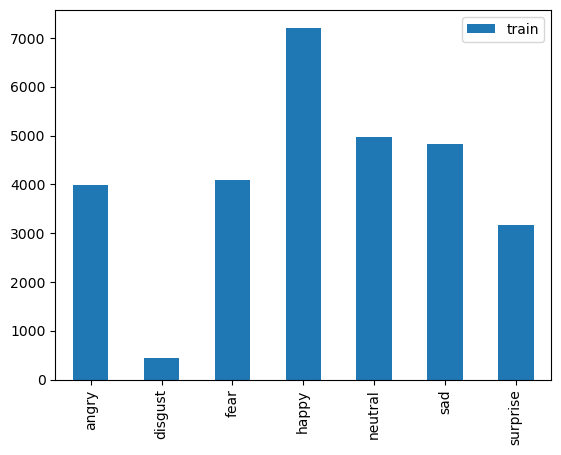

In [39]:
train_count.transpose().plot(kind='bar')

<Axes: >

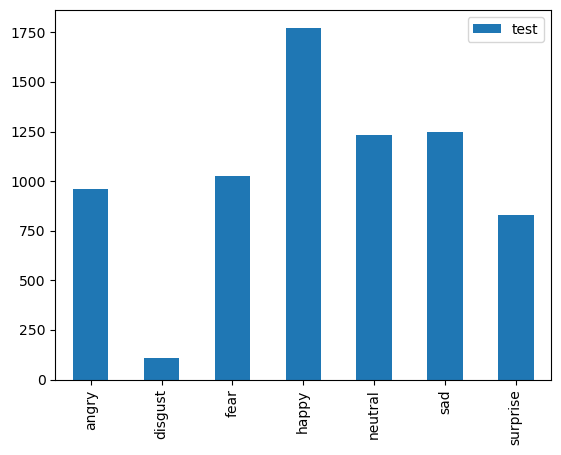

In [28]:
test_count.transpose().plot(kind='bar')

archive (1)/train/ + angry +'/'+ Training_10120469.jpg
archive (1)/train/ + disgust +'/'+ Training_10598340.jpg
archive (1)/train/ + fear +'/'+ Training_10031494.jpg
archive (1)/train/ + happy +'/'+ Training_10046809.jpg
archive (1)/train/ + neutral +'/'+ Training_10031781.jpg
archive (1)/train/ + sad +'/'+ Training_10031481.jpg
archive (1)/train/ + surprise +'/'+ Training_1002457.jpg


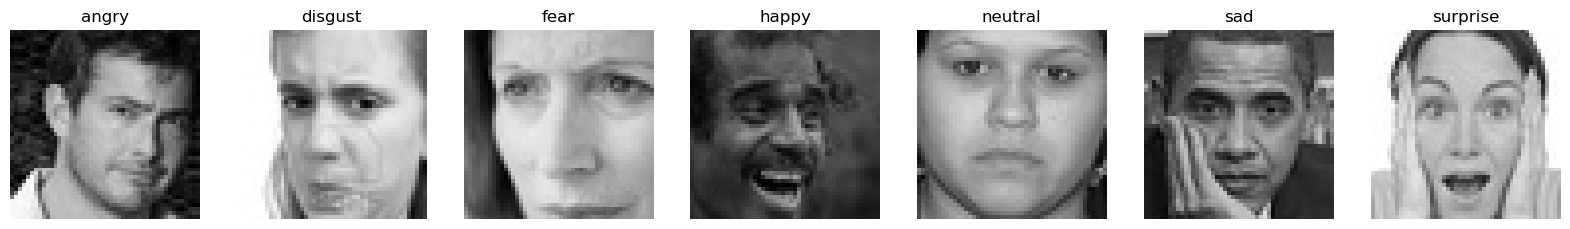

In [44]:
plt.figure(figsize = (20, 20))
i = 1
for expression in os.listdir(train_dir):
    print(f"{train_dir} + {expression} +'/'+ {os.listdir(train_dir + expression)[1]}")
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

###**Data Augmentation**

In [30]:
train_datagen = ImageDataGenerator(
                                         rotation_range = 30,
                                         width_shift_range = 0.2,
                                         height_shift_range = 0.2,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         fill_mode='nearest'
                                         #zoom_range = 0.2,
                                         #validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255
                                         #validation_split = 0.2
                                       )

In [31]:
img_size = 48

In [32]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical"
                                                             )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


###**MODEL**

In [33]:
model = tf.keras.models.Sequential()   

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu')) 
model.add(Dense(7, activation='softmax'))

    #Compliling the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_24 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_25 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                      

In [35]:
batch_size=64
epochs=100

In [36]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-10),
              EarlyStopping(monitor='val_loss', patience=15)]

In [50]:
history = model.fit(           
                        x=train_generator,
                        epochs = 1,
                        validation_data = validation_generator,
                        callbacks=callbacks
                    )

 19/449 [>.............................] - ETA: 10:34 - loss: 17.9685 - accuracy: 0.1727

KeyboardInterrupt: 

###**EVALUATION**

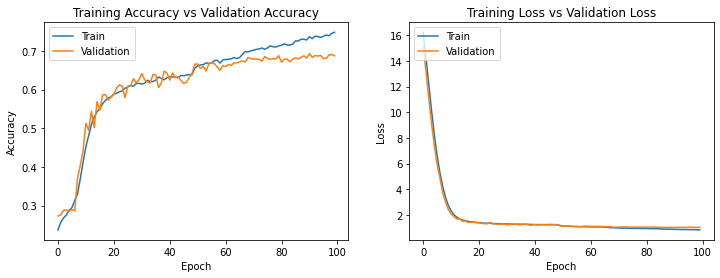

In [19]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.savefig('training.jpg')
plt.show()

In [20]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

98/98 [==============================] - 8s 84ms/step - loss: 1.0361 - accuracy: 0.6873
final train accuracy = 79.13 , validation accuracy = 68.73


###**CONFUSION MATRIX**

In [21]:
predictions = model.predict(validation_generator)

In [22]:
label_dict = {0:'Angry',1:'Fear',2:'Happy',3:'Neutral',4:'Sad'}

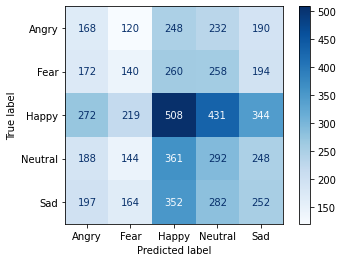

In [23]:

c_matrix = confusion_matrix(validation_generator.classes, predictions.argmax(axis=1))
#print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=label_dict.values())
cm_display.plot(cmap=plt.cm.Blues,xticks_rotation="horizontal")
plt.show()

###**TESTING**

(48, 48)


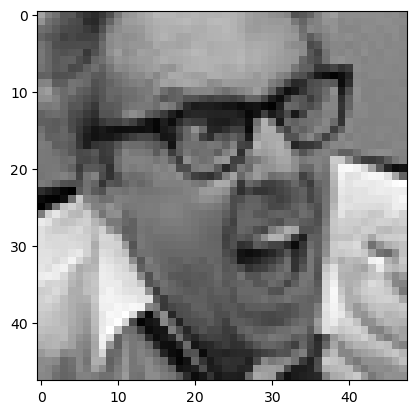

In [49]:
img = cv2.imread("archive (1)/train/angry/Training_3908.jpg",0)
plt.imshow(img,'gray')
print(img.shape)

###**SAVE**

In [ ]:
model.save('emotion_model.h5')
#saving model json
model_json = model.to_json()
with open("emotion_model1.json", "w") as json_file:
    json_file.write(model_json)